In [1]:
#Input Library 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
#memasukkan data 
train = pd.read_csv("/content/drive/MyDrive/Datasets/Praktisi/Pertemuan 2/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Datasets/Praktisi/Pertemuan 2/test.csv")

In [3]:
#melihat data 5 baris pertama 
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], 
                      test.loc[:,'MSSubClass':'SaleCondition']))
#menggabungkan objek/ kolom Msubclass dengan sale condition

Data preprocessing

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5e6494f950>,
      dtype=object)

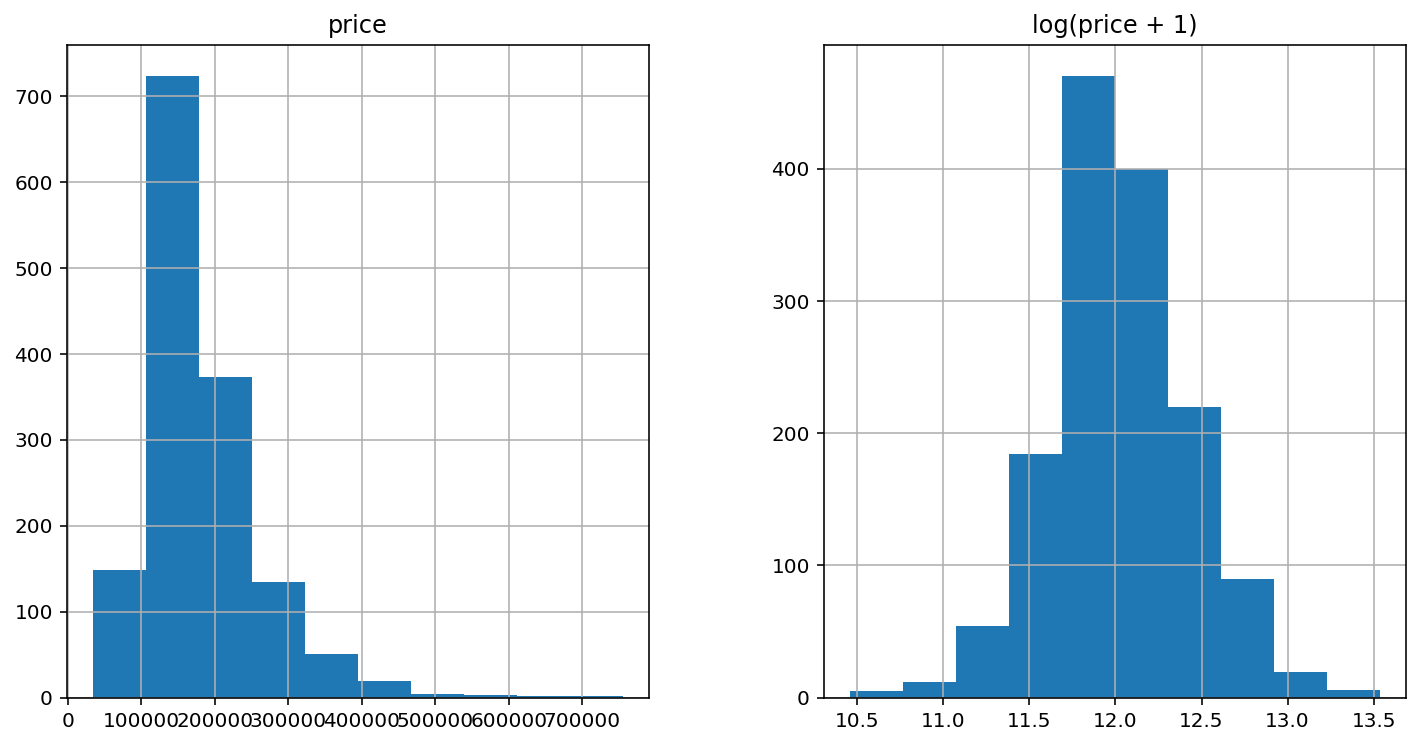

In [5]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0) # menampilkan animasi pada plot
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
#mengubah fitur skewed numerik dengan mengambil log (fitur + 1) yang membuat fitur lebih normal
prices.hist() #memunculkan histogram 

In [6]:
#mengubah target
train["SalePrice"] = np.log1p(train["SalePrice"])

#mengubah skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [7]:
all_data = pd.get_dummies(all_data) 
#Fungsi get_dummies digunakan untuk mengubah variabel kategorikal menjadi variabel numerika

In [8]:
#mengisi NA / nilai kosong dengan mean kolom:
all_data = all_data.fillna(all_data.mean())

In [9]:
#cremembuat matrices dengan menggunakan sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

MODELS


Menggunakan model regresi linier reguler dari  scikit learn. menggunakan regularisasi l_1(Lasso) dan l_2(Ridge). pertama  mendefinisikan fungsi yang mengembalikan kesalahan rmse validasi silang sehingga kami dapat mengevaluasi model dan memilih parterbaik

In [10]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [11]:
model_ridge = Ridge()

Parameter penyetelan utama untuk model Ridge adalah  alpha - a regularization parameteri yang mengukur seberapa fleksibel model yang dibuat. Semakin tinggi regularisasi, semakin kecil kemungkinan model  menjadi overfit. Namun itu juga akan kehilangan fleksibilitas dan mungkin tidak menangkap semua sinyal dalam data

In [12]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

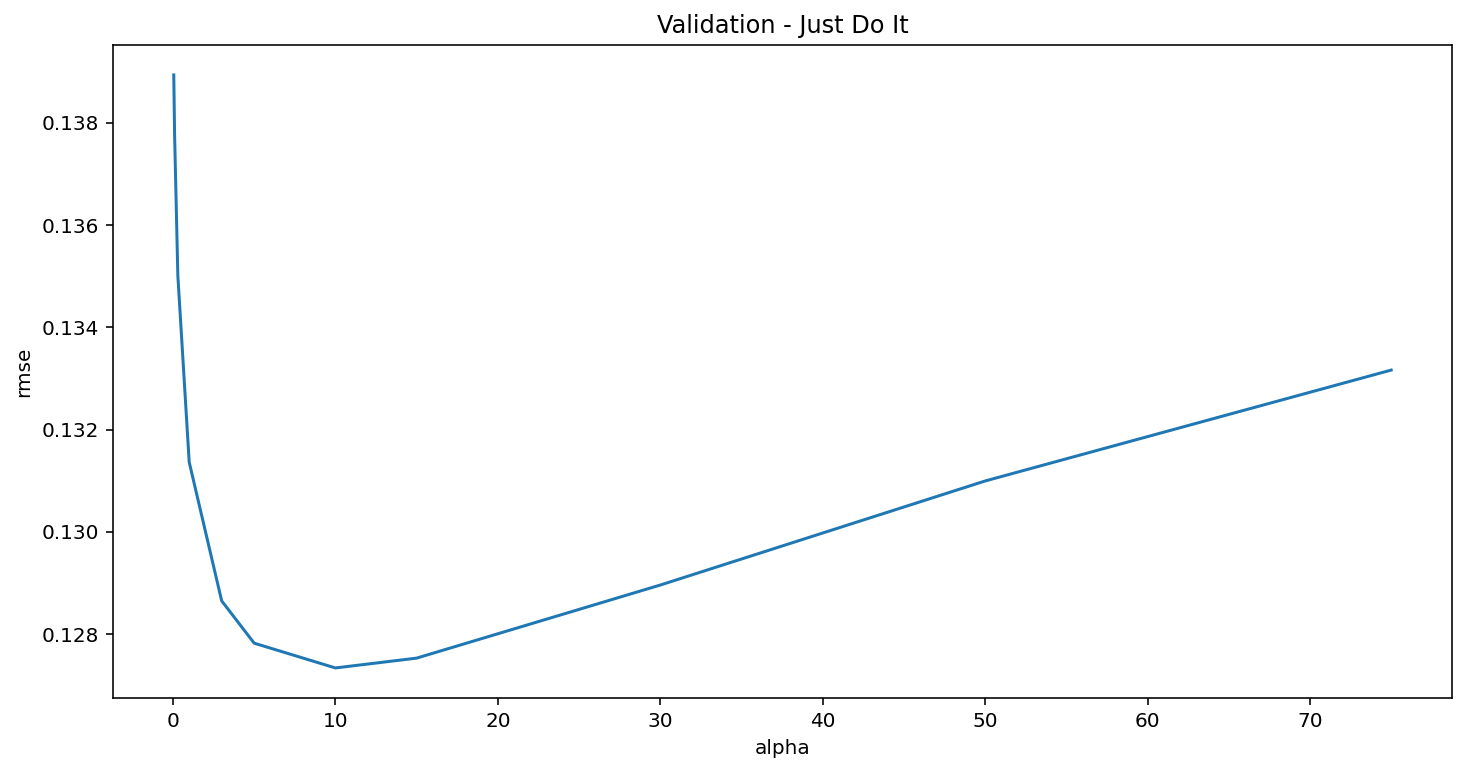

In [13]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

Ketika alpha terlalu besar, regularisasi terlalu kuat dan model tidak dapat menangkap semua kompleksitas dalam data. Namun jika kita membiarkan model terlalu fleksibel (alpha kecil), model mulai overfit. Nilai alpha = 10 kira-kira tepat berdasarkan plot di atas

In [14]:
cv_ridge.min() #melihat nilai minimum 

0.12733734668670754

In [15]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [16]:
rmse_cv(model_lasso).mean() #nilai rata-rata

0.12256735885048131

metode Lasso berhasil dengan baik. menggunakan yang ini untuk memprediksi di set pengujian. Hal menarik lainnya tentang Lasso adalah ia melakukan pemilihan fitur untuk Anda - menyetel koefisien fitur yang dianggap tidak penting menjadi nol. Mari kita lihat koefisiennya:

In [17]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [18]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 178 variables


metode Lasso berjalan dengan baik. Namun satu hal yang perlu diperhatikan di sini adalah bahwa fitur yang dipilih belum tentu yang "benar" 

terutama karena ada banyak fitur collinear dalam kumpulan data ini. Satu ide untuk dicoba di sini adalah menjalankan Lasso beberapa kali pada sampel yang di-boost dan melihat seberapa stabil pemilihan fiturnya.

Kita juga dapat melihat langsung pada koefisien yang paling penting:

In [19]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

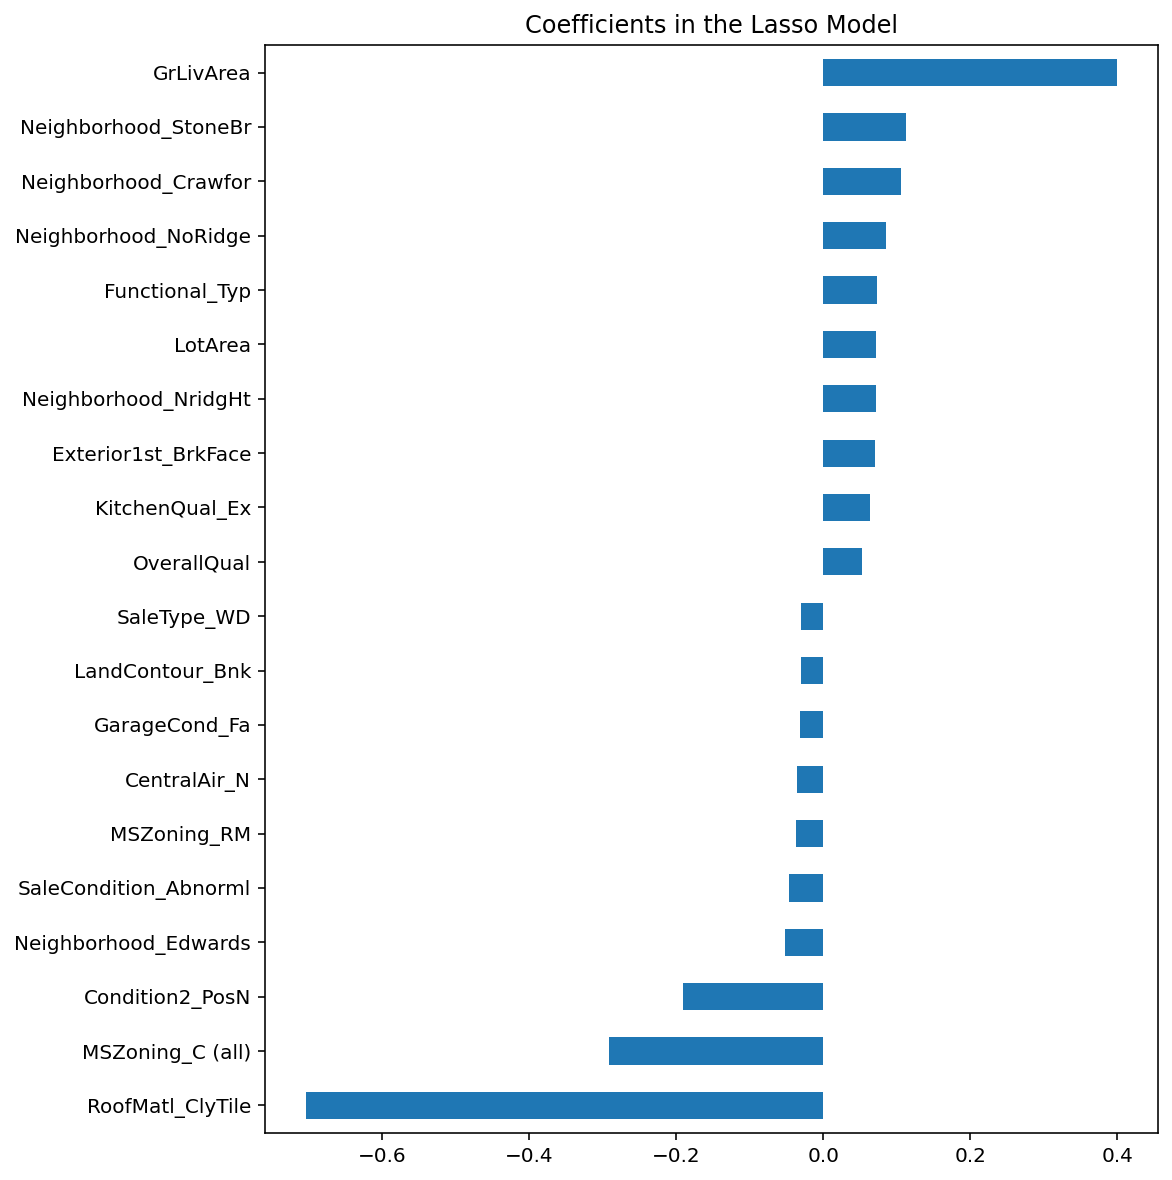

In [20]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

Fitur positif yang paling penting adalah GrLivArea Kemudian beberapa fitur lokasi dan kualitas lainnya memberikan kontribusi positif. Beberapa fitur negatif kurang masuk akal dan layak untuk diteliti lebih lanjut, sepertinya fitur tersebut mungkin berasal dari variabel kategori yang tidak seimbang.

ini adalah koefisien aktual dalam model Anda, sehingga dapat mengatakan dengan tepat mengapa harga yang diprediksi seperti itu. Satu-satunya masalah di sini adalah bahwa kami mengubah log_ baik target dan fitur numerik sehingga besaran sebenarnya agak sulit untuk ditafsirkan.

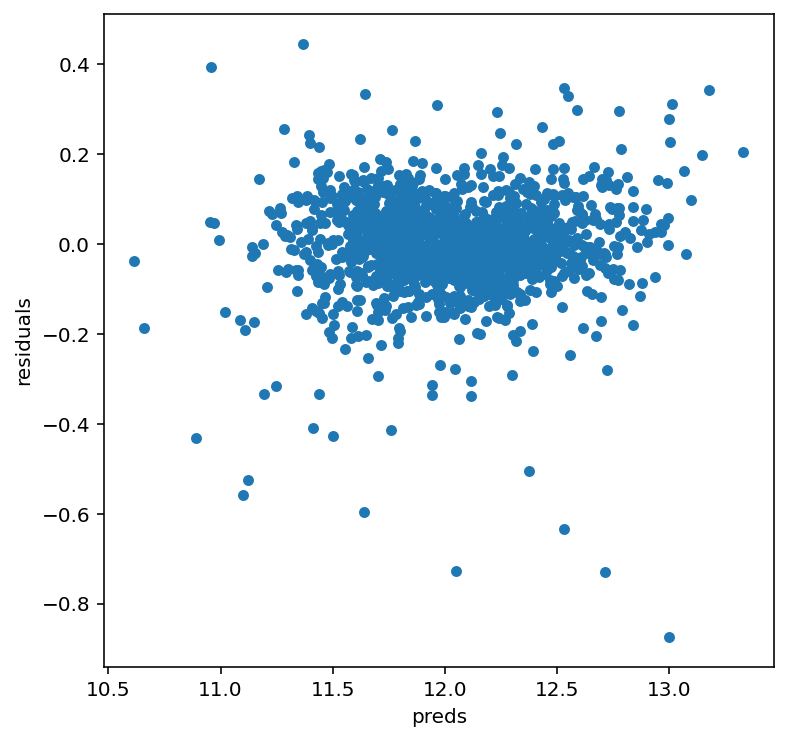

In [21]:
#melihat residu
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

residual plot terlihat cukup bagus. Untuk menyelesaikannya, mari kita prediksi di set tes dan d submit on the leaderboard

Menambahkan model xgboost

In [22]:
import xgboost as xgb

In [23]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

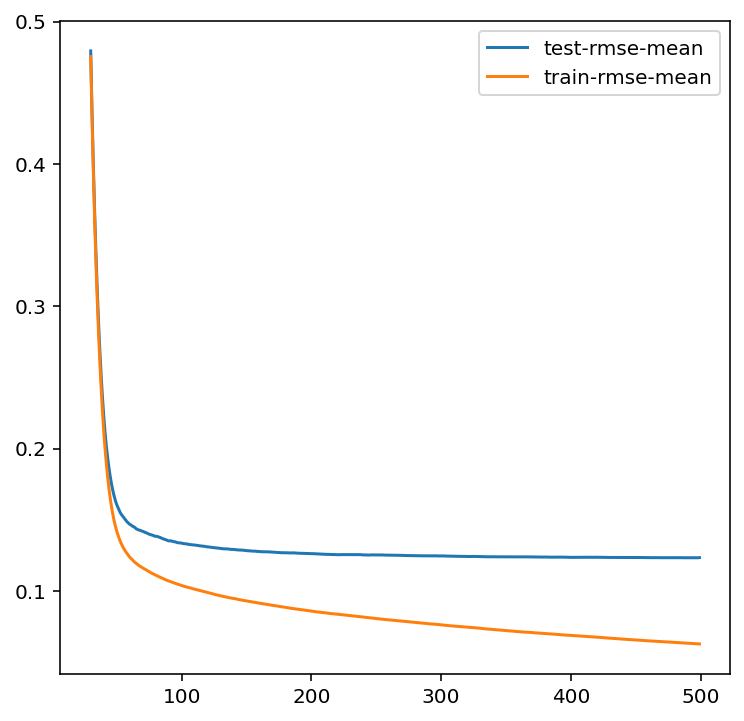

In [24]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [25]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv


In [26]:
model_xgb.fit(X_train, y)

[01:29:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=2, n_estimators=360)

In [27]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

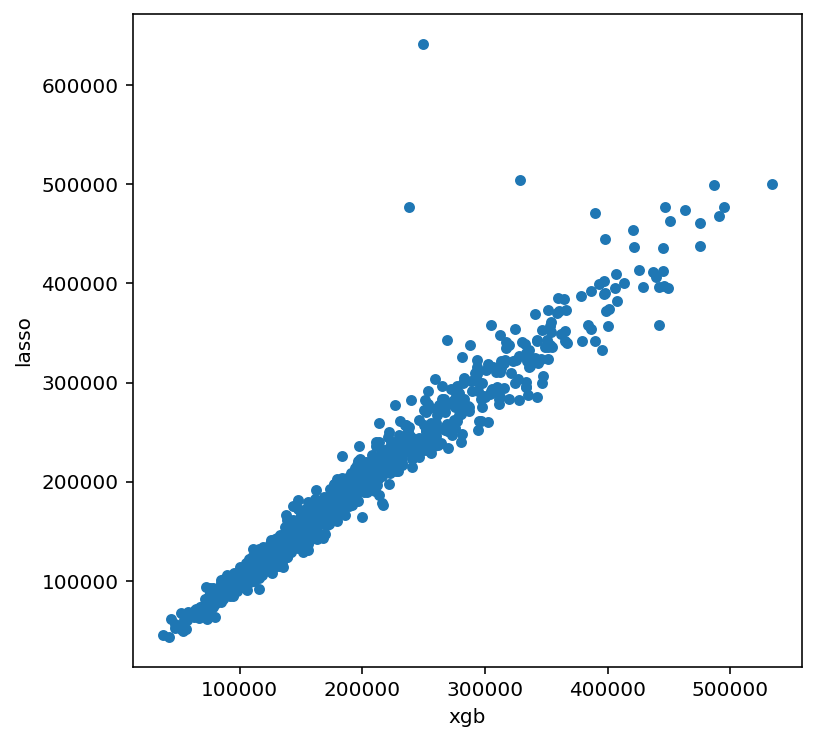

In [28]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [29]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [30]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("ridge_sol.csv", index = False)

In [40]:
ridge_sol = pd.read_csv('/content/ridge_sol.csv')
ridge_sol

,id,SalePrice
0,1461,120129.316383
1,1462,153008.789313
2,1463,181999.671772
3,1464,195952.284998
4,1465,197477.812587
...,...,...
1454,2915,87496.343669
1455,2916,85034.583020
1456,2917,165128.542251
1457,2918,119034.149412


In [31]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [32]:
X_train = StandardScaler().fit_transform(X_train)

In [33]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 3)

In [34]:
X_tr.shape #melihat banyak baris dan kolom 

(1095, 288)

In [35]:
X_tr

array([[ 1.00573733,  0.68066137, -0.46001991, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184,  0.60296111,  0.03113183, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184, -0.02865265, -0.74027492, ..., -0.11785113,
         0.4676514 , -0.30599503],
       ...,
       [ 0.16426234, -0.87075036, -0.81954431, ..., -0.11785113,
        -2.13834494, -0.30599503],
       [ 0.92361154, -0.30038284, -0.44275864, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [ 0.83656519,  1.98505948,  0.46455838, ..., -0.11785113,
         0.4676514 , -0.30599503]])

In [36]:
model = Sequential()
model.add(Dense(256, activation="relu", input_dim = X_train.shape[1]))

model.compile(loss = "mse", optimizer = "adam")

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               73984     
                                                                 
Total params: 73,984
Trainable params: 73,984
Non-trainable params: 0
_________________________________________________________________


In [38]:
hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val))

35/35 [==============================] - 2s 12ms/step - loss: 134.3391 - val_loss: 131.7553


12/12 [==============================] - 0s 2ms/step


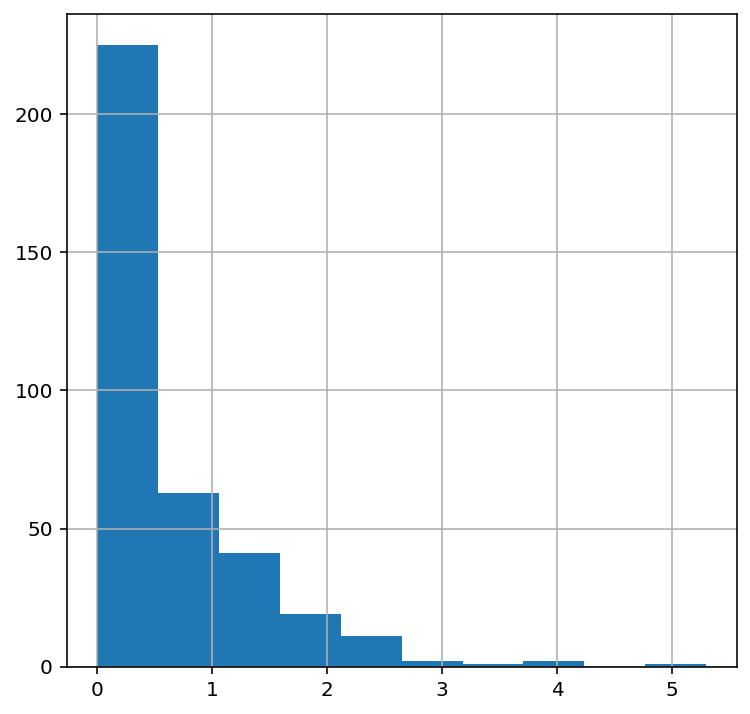

In [39]:
pd.Series(model.predict(X_val)[:,0]).hist()